In [ ]:
%load_ext autoreload
%autoreload 2

# Low-rank Approximation Model based on Covariance between Ratings and Embeddings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.stats import normaltest

In [40]:
from lrann.datasets import DataLoader, random_train_test_split
from lrann.estimators import ImplicitEst, ExplicitEst
from lrann.models import BilinearNet
from lrann.utils import is_cuda_available

In [ ]:
def get_cov(X, Y, use_zero_mean=False):
    """
    X: ratings
    Y: cov_mbeddings
    """
    result = np.zeros((2,2))
    
    if use_zero_mean:
        result[0,0] = np.mean(X*X)
        result[1,1] = np.mean(Y*Y)
        result[1,0] = result[0,1] = np.mean(X*Y)
    else:
        result = np.cov(np.vstack([X, Y]))
    
    return result

In [ ]:
def get_corr_coef(X, Y, corr_type='pearson'):
    if corr_type == 'pearson':
        return np.corrcoef(X, Y)[0,1]
    elif corr_type == 'kendalltau':
        return kendalltau(np.argsort(X), np.argsort(Y))[0]
    elif corr_type == 'spearman':
        return spearmanr(X, Y)[0]

In [ ]:
CHECK_NORMAL_DIST = True

def get_entity_corr_coef(interactions: coo_matrix, entity_id: int, entity_type: str, embeddings: dict,
                         ignore_sparse_zeros=True, use_zero_mean=False, corr_type='pearson'):
    """
    Assumes a rating matrix with rows for users and columns for items
    """
    p = embeddings['user'].shape[1]
    cov_for_p_variables = []
    
    if entity_type == 'user':
        embed = embeddings['user'][entity_id]
        # embedding used for covariance computation
        cov_embed = embeddings['item']
        # ratings used for covariance computation
        ratings = np.squeeze(np.asarray(interactions.tocsr()[entity_id, :].todense()))
    elif entity_type == 'item':
        embed = embeddings['item'][entity_id]
        # embedding used for covariance computation
        cov_embed = embeddings['user']
        # ratings used for covariance computation
        ratings = np.squeeze(np.asarray(interactions.tocsr()[:, entity_id].todense()))
    
    if ignore_sparse_zeros:
        idx = np.where(ratings!=0)[0]
        ratings = ratings[idx]
        cov_embed = cov_embed[idx]
    
    for k in range(p):
        cov_embed_latent_variables_at_k = cov_embed[:, k]
        cov_mat_for_k = get_cov(ratings, cov_embed_latent_variables_at_k,
                                use_zero_mean=use_zero_mean)
        cov_for_k = cov_mat_for_k[0, 1]
        cov_for_p_variables.append(cov_for_k)
    
    
    if CHECK_NORMAL_DIST:
        alpha = 1e-3
        p_embed = normaltest(embed)[1]
        p_cov_for_p_variables = normaltest(cov_for_p_variables)[1]
        if p_embed < alpha:
            print(f"{entity_type}-{entity_id}: Entity Embeddings are unlikely normally distributed")
        if p_cov_for_p_variables < alpha:
            print(f"{entity_type}-{entity_id}: Covariances are unlikely normally distributed")
    
    cov_for_p_variables = np.array(cov_for_p_variables)
    corr_coef = get_corr_coef(embed, cov_for_p_variables, corr_type=corr_type)

    return corr_coef

## 1.  Implicit Positive and Negative Feedback

### Data Preprocessing

In [ ]:
data = DataLoader().load_movielens('100k')
data.binarize_(use_user_mean=True)

In [ ]:
data.n_users

In [ ]:
data.n_items

### Create Scenarios

In [ ]:
params = {
    'min_rating': None,  # 5.0
    'explicit': False,
    'drop_negatives': False,
    'pos_value': 1.0,
    'neg_value': -1.0
}

entity_nums = {
    'user': data.n_users,
    'item': data.n_items
}

loss = 'bpr'
p = 16  # no of latent variables for user and item embeddings
n_epochs = 12

ignore_sparse_zeros = True
use_zero_mean = False  # ratings have mean near 0 and embeddings generally have mean around 0 as well

In [11]:
pd.Series(data.ratings).value_counts()

### Train Low-rank Approximation Model

In [12]:
mf_model = BilinearNet(data.n_users, data.n_items, embedding_dim=p, sparse=False)
mf_est = ImplicitEst(model=mf_model,
                     n_iter=n_epochs, 
                     use_cuda=is_cuda_available())
mf_est.fit(data, verbose=True)

Epoch 0: loss 0.27601647858276285
Epoch 1: loss 0.1564070956337119
Epoch 2: loss 0.13406343121308512
Epoch 3: loss 0.12004143421344346
Epoch 4: loss 0.1068543248341849
Epoch 5: loss 0.10086114513380501
Epoch 6: loss 0.09500337997687801
Epoch 7: loss 0.09016122215139079
Epoch 8: loss 0.08671094723008006
Epoch 9: loss 0.08439074197150578
Epoch 10: loss 0.08165123696831353
Epoch 11: loss 0.07959251102239726


## Obtain Model Parameters (Latent Vectors and Baseline Estimators)

In [13]:
embeddings = {}
embeddings['user'] = mf_model.user_embeddings.weight.detach().numpy()
embeddings['item'] = mf_model.item_embeddings.weight.detach().numpy()

In [ ]:
user_biases = mf_model.user_biases.weight.detach().numpy()
item_biases = mf_model.item_biases.weight.detach().numpy()

## Analyze Rating-Embedding Covariances

In [ ]:
interactions = data.tocoo()

In [ ]:
interactions

### User View
Skip users with only one rating

In [ ]:
results = {}
entity_type = 'user'
user_counts = np.array((interactions.todense() != 0).astype(int).sum(axis=1)).flatten()

for corr_type in ['pearson']:  #, 'kendalltau', 'spearman']:
    corr_stats = []
    for entity_id in range(entity_nums[entity_type]):
        if user_counts[entity_id] > 1:
            corr_stats.append(get_entity_corr_coef(interactions,
                                                   entity_id,
                                                   entity_type,
                                                   embeddings,
                                                   ignore_sparse_zeros=ignore_sparse_zeros,
                                                   use_zero_mean=use_zero_mean,
                                                   corr_type=corr_type))

    corr_stats = pd.Series(corr_stats)
    print("\nEntity Type:", entity_type)
    print("Ignore Sparse Zeros:", ignore_sparse_zeros)
    print("Use Zero Mean:", use_zero_mean)
    print("Correlation Type:", corr_type)
    print("---\nStats:\n---")
    print(corr_stats.describe())
    print()

    results[(ignore_sparse_zeros, use_zero_mean, corr_type)] = corr_stats

#### Visualize Results

In [ ]:
for idx, key in enumerate(list(results.keys())):
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0, density=False)
    plt.xlabel(r'$\rho_{user}$', fontdict={'fontsize': 18})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.41, 5,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Implicit User View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    print(results[key].describe())
    print()
plt.show()

### Item View
Skip items with only one rating

In [ ]:
results = {}
entity_type = 'item'
item_counts = np.array((interactions.todense() != 0).astype(int).sum(axis=0)).flatten()

for corr_type in ['pearson']:  #, 'kendalltau', 'spearman']:
    corr_stats = []
    for entity_id in range(entity_nums[entity_type]):
        if item_counts[entity_id] > 1:
            corr_stats.append(get_entity_corr_coef(interactions,
                                                   entity_id,
                                                   entity_type,
                                                   embeddings,
                                                   ignore_sparse_zeros=ignore_sparse_zeros,
                                                   use_zero_mean=use_zero_mean,
                                                   corr_type=corr_type))

    corr_stats = pd.Series(corr_stats)
    print("\nEntity Type:", entity_type)
    print("Ignore Sparse Zeros:", ignore_sparse_zeros)
    print("Use Zero Mean:", use_zero_mean)
    print("Correlation Type:", corr_type)
    print("---\nStats:\n---")
    print(corr_stats.describe())
    print()

    results[(ignore_sparse_zeros, use_zero_mean, corr_type)] = corr_stats

#### Visualize Results

In [ ]:
for idx, key in enumerate(list(results.keys())):
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0)
    plt.xlabel(r'$\rho_{item}$', fontdict={'fontsize': 18})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.24, 10,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Implicit Item View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    print(results[key].describe())
    print()
plt.show()

In [ ]:
np.round(results[key].describe().values,4).reshape([-1,1])

## 2. Explicit Feedback

### Data Preprocessing

In [20]:
data = DataLoader().load_movielens('100k')
# data.binarize_(use_user_mean=True)

### Create Scenarios

In [24]:
params = {
    'min_rating': 0.5,  # use all explicit ratings
    'explicit': True,
    'drop_negatives': False  # True
}

entity_nums = {
    'user': data.n_users,
    'item': data.n_items
}

loss = 'bpr'   # 'logistic'
p = 16  # no of latent variables for user and item embeddings
epochs = 20

ignore_sparse_zeros = True
use_zero_mean = True  # to account for high user biases

results = {}

### Train Low-rank Approximation Model

In [25]:
mf_model = BilinearNet(data.n_users, data.n_items, embedding_dim=p, sparse=False)
mf_est = ImplicitEst(model=mf_model,
                     n_iter=n_epochs, 
                     use_cuda=is_cuda_available())
mf_est.fit(data, verbose=True)

Epoch 0: loss 0.27118261584889164
Epoch 1: loss 0.1559018267290241
Epoch 2: loss 0.1300201501914768
Epoch 3: loss 0.11576181472406774
Epoch 4: loss 0.10375934371696359
Epoch 5: loss 0.09827497584490001
Epoch 6: loss 0.0925117371140549
Epoch 7: loss 0.0883001295310743
Epoch 8: loss 0.08465217325486583
Epoch 9: loss 0.08255409998204653
Epoch 10: loss 0.07957301841018163
Epoch 11: loss 0.07809715550203765


### Obtain Model Parameters (Latent Vectors and Baseline Estimators)

In [42]:
embeddings = {}
embeddings['user'] = mf_model.user_embeddings.weight.detach().numpy()
embeddings['item'] = mf_model.item_embeddings.weight.detach().numpy()

In [43]:
user_biases = mf_model.user_biases.weight.detach().numpy()
item_biases = mf_model.item_biases.weight.detach().numpy()

### Analyze Rating-Embedding Covariances

In [45]:
interactions = data.tocoo()

In [46]:
interactions

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in COOrdinate format>

#### User View 
Skip users with only one rating

In [47]:
entity_type = 'user'
user_counts = np.array((interactions.todense() != 0).astype(int).sum(axis=1)).flatten()

for corr_type in ['pearson']:   #, 'kendalltau', 'spearman']:
    corr_stats = []
    for entity_id in range(entity_nums[entity_type]):
        if user_counts[entity_id] > 1:
            corr_stats.append(get_entity_corr_coef(interactions,
                                                   entity_id,
                                                   entity_type,
                                                   embeddings,
                                                   ignore_sparse_zeros=ignore_sparse_zeros,
                                                   use_zero_mean=use_zero_mean,
                                                   corr_type=corr_type))

    corr_stats = pd.Series(corr_stats)
    print("\nEntity Type:", entity_type)
    print("Ignore Sparse Zeros:", ignore_sparse_zeros)
    print("Use Zero Mean:", use_zero_mean)
    print("Correlation Type:", corr_type)
    print("---\nStats:\n---")
    print(corr_stats.describe())
    print()

    results[(ignore_sparse_zeros, use_zero_mean, corr_type)] = corr_stats

/anaconda3/envs/lrann/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


user-0: Entity Embeddings are unlikely normally distributed
user-0: Covariances are unlikely normally distributed
user-1: Entity Embeddings are unlikely normally distributed
user-1: Covariances are unlikely normally distributed
user-3: Entity Embeddings are unlikely normally distributed
user-3: Covariances are unlikely normally distributed
user-4: Covariances are unlikely normally distributed
user-5: Covariances are unlikely normally distributed
user-8: Entity Embeddings are unlikely normally distributed
user-8: Covariances are unlikely normally distributed
user-10: Entity Embeddings are unlikely normally distributed
user-10: Covariances are unlikely normally distributed
user-17: Covariances are unlikely normally distributed
user-18: Covariances are unlikely normally distributed
user-19: Covariances are unlikely normally distributed
user-22: Covariances are unlikely normally distributed
user-26: Entity Embeddings are unlikely normally distributed
user-26: Covariances are unlikely norma

user-220: Covariances are unlikely normally distributed
user-221: Covariances are unlikely normally distributed
user-223: Entity Embeddings are unlikely normally distributed
user-223: Covariances are unlikely normally distributed
user-224: Entity Embeddings are unlikely normally distributed
user-224: Covariances are unlikely normally distributed
user-225: Covariances are unlikely normally distributed
user-226: Covariances are unlikely normally distributed
user-227: Entity Embeddings are unlikely normally distributed
user-231: Covariances are unlikely normally distributed
user-233: Covariances are unlikely normally distributed
user-235: Covariances are unlikely normally distributed
user-237: Covariances are unlikely normally distributed
user-243: Entity Embeddings are unlikely normally distributed
user-243: Covariances are unlikely normally distributed
user-244: Covariances are unlikely normally distributed
user-245: Covariances are unlikely normally distributed
user-248: Covariances ar

user-447: Covariances are unlikely normally distributed
user-449: Covariances are unlikely normally distributed
user-451: Covariances are unlikely normally distributed
user-452: Covariances are unlikely normally distributed
user-455: Covariances are unlikely normally distributed
user-461: Covariances are unlikely normally distributed
user-464: Entity Embeddings are unlikely normally distributed
user-464: Covariances are unlikely normally distributed
user-468: Entity Embeddings are unlikely normally distributed
user-468: Covariances are unlikely normally distributed
user-471: Covariances are unlikely normally distributed
user-472: Covariances are unlikely normally distributed
user-473: Covariances are unlikely normally distributed
user-475: Covariances are unlikely normally distributed
user-476: Covariances are unlikely normally distributed
user-478: Covariances are unlikely normally distributed
user-479: Covariances are unlikely normally distributed
user-481: Covariances are unlikely n

##### Visualize Results

count    610.000000
mean       0.901543
std        0.129743
min        0.423679
25%        0.858715
50%        0.969917
75%        0.982190
max        0.994666
dtype: float64



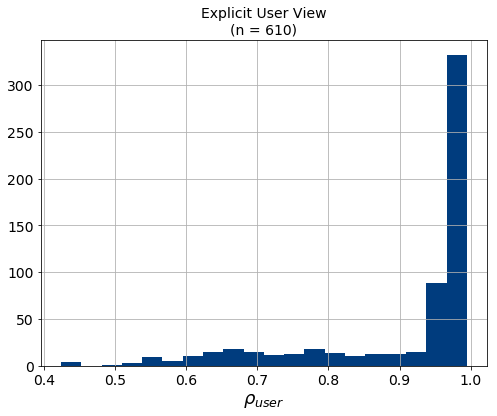

In [48]:
for idx, key in enumerate(list(results.keys())):
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.04, 5,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Explicit User View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    plt.xlabel(r'$\rho_{user}$', fontdict={'fontsize': 18})
    print(results[key].describe())
    print()
plt.show()

In [49]:
np.round(results[key].describe().values,4).reshape([-1,1])

array([[6.100e+02],
       [9.015e-01],
       [1.297e-01],
       [4.237e-01],
       [8.587e-01],
       [9.699e-01],
       [9.822e-01],
       [9.947e-01]])

#### Item View
Skip items with only one rating

In [50]:
entity_type = 'item'
item_counts = np.array((interactions.todense() != 0).astype(int).sum(axis=0)).flatten()

for corr_type in ['pearson']:   #, 'kendalltau', 'spearman']:
    corr_stats = []
    for entity_id in range(entity_nums[entity_type]):
        if item_counts[entity_id] > 1:
            corr_stats.append(get_entity_corr_coef(interactions,
                                                   entity_id,
                                                   entity_type,
                                                   embeddings,
                                                   ignore_sparse_zeros=ignore_sparse_zeros,
                                                   use_zero_mean=use_zero_mean,
                                                   corr_type=corr_type))

    corr_stats = pd.Series(corr_stats)
    print("\nEntity Type:", entity_type)
    print("Ignore Sparse Zeros:", ignore_sparse_zeros)
    print("Use Zero Mean:", use_zero_mean)
    print("Correlation Type:", corr_type)
    print("---\nStats:\n---")
    print(corr_stats.describe())
    print()

    results[(ignore_sparse_zeros, use_zero_mean, corr_type)] = corr_stats

item-0: Covariances are unlikely normally distributed
item-1: Covariances are unlikely normally distributed
item-2: Covariances are unlikely normally distributed
item-3: Covariances are unlikely normally distributed
item-4: Covariances are unlikely normally distributed
item-5: Covariances are unlikely normally distributed
item-6: Covariances are unlikely normally distributed
item-7: Covariances are unlikely normally distributed
item-8: Covariances are unlikely normally distributed
item-9: Covariances are unlikely normally distributed
item-10: Covariances are unlikely normally distributed
item-12: Covariances are unlikely normally distributed
item-13: Covariances are unlikely normally distributed
item-14: Entity Embeddings are unlikely normally distributed
item-14: Covariances are unlikely normally distributed
item-15: Covariances are unlikely normally distributed
item-16: Covariances are unlikely normally distributed
item-17: Covariances are unlikely normally distributed
item-18: Covar

item-159: Covariances are unlikely normally distributed
item-160: Covariances are unlikely normally distributed
item-161: Covariances are unlikely normally distributed
item-162: Covariances are unlikely normally distributed
item-163: Covariances are unlikely normally distributed
item-164: Covariances are unlikely normally distributed
item-165: Covariances are unlikely normally distributed
item-166: Covariances are unlikely normally distributed
item-167: Covariances are unlikely normally distributed
item-168: Covariances are unlikely normally distributed
item-169: Covariances are unlikely normally distributed
item-170: Covariances are unlikely normally distributed
item-171: Covariances are unlikely normally distributed
item-172: Covariances are unlikely normally distributed
item-173: Covariances are unlikely normally distributed
item-174: Covariances are unlikely normally distributed
item-175: Entity Embeddings are unlikely normally distributed
item-175: Covariances are unlikely normall

item-324: Covariances are unlikely normally distributed
item-325: Covariances are unlikely normally distributed
item-326: Covariances are unlikely normally distributed
item-327: Covariances are unlikely normally distributed
item-328: Covariances are unlikely normally distributed
item-329: Covariances are unlikely normally distributed
item-330: Covariances are unlikely normally distributed
item-331: Covariances are unlikely normally distributed
item-332: Entity Embeddings are unlikely normally distributed
item-332: Covariances are unlikely normally distributed
item-333: Covariances are unlikely normally distributed
item-334: Covariances are unlikely normally distributed
item-335: Covariances are unlikely normally distributed
item-336: Covariances are unlikely normally distributed
item-337: Entity Embeddings are unlikely normally distributed
item-337: Covariances are unlikely normally distributed
item-340: Covariances are unlikely normally distributed
item-341: Covariances are unlikely n

item-486: Covariances are unlikely normally distributed
item-487: Covariances are unlikely normally distributed
item-488: Covariances are unlikely normally distributed
item-490: Covariances are unlikely normally distributed
item-491: Covariances are unlikely normally distributed
item-492: Covariances are unlikely normally distributed
item-493: Covariances are unlikely normally distributed
item-494: Covariances are unlikely normally distributed
item-495: Covariances are unlikely normally distributed
item-496: Covariances are unlikely normally distributed
item-497: Covariances are unlikely normally distributed
item-498: Covariances are unlikely normally distributed
item-499: Entity Embeddings are unlikely normally distributed
item-499: Covariances are unlikely normally distributed
item-500: Covariances are unlikely normally distributed
item-501: Covariances are unlikely normally distributed
item-502: Entity Embeddings are unlikely normally distributed
item-502: Covariances are unlikely n

item-656: Covariances are unlikely normally distributed
item-658: Covariances are unlikely normally distributed
item-659: Covariances are unlikely normally distributed
item-660: Covariances are unlikely normally distributed
item-661: Covariances are unlikely normally distributed
item-662: Covariances are unlikely normally distributed
item-663: Entity Embeddings are unlikely normally distributed
item-663: Covariances are unlikely normally distributed
item-664: Covariances are unlikely normally distributed
item-665: Covariances are unlikely normally distributed
item-666: Covariances are unlikely normally distributed
item-667: Covariances are unlikely normally distributed
item-668: Covariances are unlikely normally distributed
item-669: Covariances are unlikely normally distributed
item-670: Covariances are unlikely normally distributed
item-672: Covariances are unlikely normally distributed
item-673: Covariances are unlikely normally distributed
item-674: Entity Embeddings are unlikely n

item-844: Covariances are unlikely normally distributed
item-845: Entity Embeddings are unlikely normally distributed
item-845: Covariances are unlikely normally distributed
item-846: Covariances are unlikely normally distributed
item-847: Covariances are unlikely normally distributed
item-849: Covariances are unlikely normally distributed
item-852: Entity Embeddings are unlikely normally distributed
item-852: Covariances are unlikely normally distributed
item-853: Entity Embeddings are unlikely normally distributed
item-854: Covariances are unlikely normally distributed
item-855: Covariances are unlikely normally distributed
item-856: Covariances are unlikely normally distributed
item-860: Covariances are unlikely normally distributed
item-862: Covariances are unlikely normally distributed
item-863: Covariances are unlikely normally distributed
item-864: Covariances are unlikely normally distributed
item-865: Covariances are unlikely normally distributed
item-867: Covariances are unli

item-1065: Covariances are unlikely normally distributed
item-1066: Covariances are unlikely normally distributed
item-1068: Covariances are unlikely normally distributed
item-1069: Covariances are unlikely normally distributed
item-1072: Covariances are unlikely normally distributed
item-1073: Covariances are unlikely normally distributed
item-1075: Covariances are unlikely normally distributed
item-1076: Covariances are unlikely normally distributed
item-1079: Covariances are unlikely normally distributed
item-1084: Covariances are unlikely normally distributed
item-1085: Covariances are unlikely normally distributed
item-1088: Covariances are unlikely normally distributed
item-1090: Covariances are unlikely normally distributed
item-1093: Covariances are unlikely normally distributed
item-1094: Covariances are unlikely normally distributed
item-1095: Entity Embeddings are unlikely normally distributed
item-1095: Covariances are unlikely normally distributed
item-1096: Covariances ar

item-1257: Covariances are unlikely normally distributed
item-1259: Entity Embeddings are unlikely normally distributed
item-1261: Covariances are unlikely normally distributed
item-1263: Covariances are unlikely normally distributed
item-1269: Covariances are unlikely normally distributed
item-1270: Entity Embeddings are unlikely normally distributed
item-1270: Covariances are unlikely normally distributed
item-1271: Covariances are unlikely normally distributed
item-1272: Covariances are unlikely normally distributed
item-1273: Covariances are unlikely normally distributed
item-1274: Covariances are unlikely normally distributed
item-1275: Covariances are unlikely normally distributed
item-1276: Entity Embeddings are unlikely normally distributed
item-1276: Covariances are unlikely normally distributed
item-1277: Covariances are unlikely normally distributed
item-1278: Covariances are unlikely normally distributed
item-1279: Covariances are unlikely normally distributed
item-1281: Co

item-1491: Covariances are unlikely normally distributed
item-1492: Covariances are unlikely normally distributed
item-1493: Covariances are unlikely normally distributed
item-1494: Entity Embeddings are unlikely normally distributed
item-1495: Covariances are unlikely normally distributed
item-1496: Covariances are unlikely normally distributed
item-1497: Covariances are unlikely normally distributed
item-1499: Covariances are unlikely normally distributed
item-1500: Covariances are unlikely normally distributed
item-1501: Covariances are unlikely normally distributed
item-1502: Entity Embeddings are unlikely normally distributed
item-1502: Covariances are unlikely normally distributed
item-1503: Covariances are unlikely normally distributed
item-1507: Covariances are unlikely normally distributed
item-1508: Covariances are unlikely normally distributed
item-1509: Covariances are unlikely normally distributed
item-1511: Covariances are unlikely normally distributed
item-1513: Covarian

item-1682: Covariances are unlikely normally distributed
item-1683: Covariances are unlikely normally distributed
item-1684: Covariances are unlikely normally distributed
item-1685: Covariances are unlikely normally distributed
item-1686: Covariances are unlikely normally distributed
item-1690: Covariances are unlikely normally distributed
item-1692: Covariances are unlikely normally distributed
item-1694: Entity Embeddings are unlikely normally distributed
item-1694: Covariances are unlikely normally distributed
item-1696: Covariances are unlikely normally distributed
item-1697: Covariances are unlikely normally distributed
item-1698: Covariances are unlikely normally distributed
item-1699: Covariances are unlikely normally distributed
item-1700: Covariances are unlikely normally distributed
item-1701: Covariances are unlikely normally distributed
item-1703: Entity Embeddings are unlikely normally distributed
item-1703: Covariances are unlikely normally distributed
item-1705: Covarian

item-1969: Covariances are unlikely normally distributed
item-1974: Covariances are unlikely normally distributed
item-1975: Covariances are unlikely normally distributed
item-1980: Entity Embeddings are unlikely normally distributed
item-1980: Covariances are unlikely normally distributed
item-1993: Entity Embeddings are unlikely normally distributed
item-1997: Covariances are unlikely normally distributed
item-2000: Entity Embeddings are unlikely normally distributed
item-2023: Entity Embeddings are unlikely normally distributed
item-2037: Covariances are unlikely normally distributed
item-2038: Covariances are unlikely normally distributed
item-2039: Covariances are unlikely normally distributed
item-2040: Covariances are unlikely normally distributed
item-2041: Covariances are unlikely normally distributed
item-2042: Covariances are unlikely normally distributed
item-2043: Covariances are unlikely normally distributed
item-2044: Covariances are unlikely normally distributed
item-20

item-2224: Covariances are unlikely normally distributed
item-2225: Entity Embeddings are unlikely normally distributed
item-2225: Covariances are unlikely normally distributed
item-2226: Covariances are unlikely normally distributed
item-2230: Covariances are unlikely normally distributed
item-2232: Covariances are unlikely normally distributed
item-2235: Covariances are unlikely normally distributed
item-2236: Covariances are unlikely normally distributed
item-2237: Covariances are unlikely normally distributed
item-2238: Covariances are unlikely normally distributed
item-2240: Covariances are unlikely normally distributed
item-2242: Covariances are unlikely normally distributed
item-2243: Covariances are unlikely normally distributed
item-2244: Covariances are unlikely normally distributed
item-2246: Entity Embeddings are unlikely normally distributed
item-2246: Covariances are unlikely normally distributed
item-2250: Covariances are unlikely normally distributed
item-2265: Covarian

item-2477: Covariances are unlikely normally distributed
item-2479: Covariances are unlikely normally distributed
item-2483: Covariances are unlikely normally distributed
item-2486: Covariances are unlikely normally distributed
item-2487: Covariances are unlikely normally distributed
item-2488: Covariances are unlikely normally distributed
item-2489: Covariances are unlikely normally distributed
item-2490: Covariances are unlikely normally distributed
item-2491: Covariances are unlikely normally distributed
item-2492: Covariances are unlikely normally distributed
item-2493: Entity Embeddings are unlikely normally distributed
item-2493: Covariances are unlikely normally distributed
item-2494: Covariances are unlikely normally distributed
item-2495: Covariances are unlikely normally distributed
item-2496: Covariances are unlikely normally distributed
item-2497: Covariances are unlikely normally distributed
item-2500: Covariances are unlikely normally distributed
item-2501: Entity Embeddi

item-2696: Covariances are unlikely normally distributed
item-2700: Covariances are unlikely normally distributed
item-2701: Covariances are unlikely normally distributed
item-2703: Covariances are unlikely normally distributed
item-2706: Covariances are unlikely normally distributed
item-2711: Covariances are unlikely normally distributed
item-2712: Covariances are unlikely normally distributed
item-2716: Covariances are unlikely normally distributed
item-2719: Covariances are unlikely normally distributed
item-2720: Entity Embeddings are unlikely normally distributed
item-2724: Covariances are unlikely normally distributed
item-2725: Entity Embeddings are unlikely normally distributed
item-2729: Covariances are unlikely normally distributed
item-2732: Covariances are unlikely normally distributed
item-2735: Covariances are unlikely normally distributed
item-2736: Entity Embeddings are unlikely normally distributed
item-2750: Covariances are unlikely normally distributed
item-2753: Co

item-3078: Covariances are unlikely normally distributed
item-3086: Entity Embeddings are unlikely normally distributed
item-3088: Covariances are unlikely normally distributed
item-3090: Covariances are unlikely normally distributed
item-3094: Entity Embeddings are unlikely normally distributed
item-3094: Covariances are unlikely normally distributed
item-3095: Covariances are unlikely normally distributed
item-3101: Covariances are unlikely normally distributed
item-3105: Covariances are unlikely normally distributed
item-3106: Covariances are unlikely normally distributed
item-3108: Entity Embeddings are unlikely normally distributed
item-3113: Covariances are unlikely normally distributed
item-3117: Covariances are unlikely normally distributed
item-3123: Covariances are unlikely normally distributed
item-3126: Covariances are unlikely normally distributed
item-3127: Covariances are unlikely normally distributed
item-3129: Entity Embeddings are unlikely normally distributed
item-31

item-3378: Entity Embeddings are unlikely normally distributed
item-3380: Entity Embeddings are unlikely normally distributed
item-3384: Covariances are unlikely normally distributed
item-3413: Covariances are unlikely normally distributed
item-3418: Entity Embeddings are unlikely normally distributed
item-3420: Covariances are unlikely normally distributed
item-3422: Entity Embeddings are unlikely normally distributed
item-3422: Covariances are unlikely normally distributed
item-3424: Covariances are unlikely normally distributed
item-3426: Covariances are unlikely normally distributed
item-3455: Entity Embeddings are unlikely normally distributed
item-3458: Entity Embeddings are unlikely normally distributed
item-3486: Covariances are unlikely normally distributed
item-3490: Covariances are unlikely normally distributed
item-3497: Covariances are unlikely normally distributed
item-3498: Covariances are unlikely normally distributed
item-3499: Entity Embeddings are unlikely normally d

item-4073: Entity Embeddings are unlikely normally distributed
item-4074: Entity Embeddings are unlikely normally distributed
item-4079: Entity Embeddings are unlikely normally distributed
item-4079: Covariances are unlikely normally distributed
item-4082: Covariances are unlikely normally distributed
item-4084: Covariances are unlikely normally distributed
item-4092: Covariances are unlikely normally distributed
item-4093: Entity Embeddings are unlikely normally distributed
item-4094: Entity Embeddings are unlikely normally distributed
item-4097: Entity Embeddings are unlikely normally distributed
item-4099: Entity Embeddings are unlikely normally distributed
item-4104: Entity Embeddings are unlikely normally distributed
item-4108: Entity Embeddings are unlikely normally distributed
item-4115: Entity Embeddings are unlikely normally distributed
item-4119: Entity Embeddings are unlikely normally distributed
item-4126: Entity Embeddings are unlikely normally distributed
item-4140: Covar

item-4764: Entity Embeddings are unlikely normally distributed
item-4790: Entity Embeddings are unlikely normally distributed
item-4793: Covariances are unlikely normally distributed
item-4794: Covariances are unlikely normally distributed
item-4802: Covariances are unlikely normally distributed
item-4819: Entity Embeddings are unlikely normally distributed
item-4830: Entity Embeddings are unlikely normally distributed
item-4830: Covariances are unlikely normally distributed
item-4833: Entity Embeddings are unlikely normally distributed
item-4833: Covariances are unlikely normally distributed
item-4834: Entity Embeddings are unlikely normally distributed
item-4834: Covariances are unlikely normally distributed
item-4839: Entity Embeddings are unlikely normally distributed
item-4840: Covariances are unlikely normally distributed
item-4844: Covariances are unlikely normally distributed
item-4847: Covariances are unlikely normally distributed
item-4849: Covariances are unlikely normally d

item-5081: Covariances are unlikely normally distributed
item-5083: Covariances are unlikely normally distributed
item-5084: Covariances are unlikely normally distributed
item-5086: Covariances are unlikely normally distributed
item-5087: Covariances are unlikely normally distributed
item-5088: Entity Embeddings are unlikely normally distributed
item-5091: Entity Embeddings are unlikely normally distributed
item-5094: Covariances are unlikely normally distributed
item-5097: Covariances are unlikely normally distributed
item-5104: Covariances are unlikely normally distributed
item-5105: Covariances are unlikely normally distributed
item-5106: Covariances are unlikely normally distributed
item-5109: Covariances are unlikely normally distributed
item-5115: Covariances are unlikely normally distributed
item-5117: Covariances are unlikely normally distributed
item-5120: Covariances are unlikely normally distributed
item-5121: Covariances are unlikely normally distributed
item-5122: Covarian

item-5626: Covariances are unlikely normally distributed
item-5630: Entity Embeddings are unlikely normally distributed
item-5630: Covariances are unlikely normally distributed
item-5631: Entity Embeddings are unlikely normally distributed
item-5666: Covariances are unlikely normally distributed
item-5669: Covariances are unlikely normally distributed
item-5671: Covariances are unlikely normally distributed
item-5675: Covariances are unlikely normally distributed
item-5676: Covariances are unlikely normally distributed
item-5683: Covariances are unlikely normally distributed
item-5690: Covariances are unlikely normally distributed
item-5694: Entity Embeddings are unlikely normally distributed
item-5694: Covariances are unlikely normally distributed
item-5695: Covariances are unlikely normally distributed
item-5696: Covariances are unlikely normally distributed
item-5697: Entity Embeddings are unlikely normally distributed
item-5697: Covariances are unlikely normally distributed
item-56

item-6354: Entity Embeddings are unlikely normally distributed
item-6367: Covariances are unlikely normally distributed
item-6369: Entity Embeddings are unlikely normally distributed
item-6369: Covariances are unlikely normally distributed
item-6370: Covariances are unlikely normally distributed
item-6371: Covariances are unlikely normally distributed
item-6374: Covariances are unlikely normally distributed
item-6375: Covariances are unlikely normally distributed
item-6376: Covariances are unlikely normally distributed
item-6379: Covariances are unlikely normally distributed
item-6380: Covariances are unlikely normally distributed
item-6382: Covariances are unlikely normally distributed
item-6383: Covariances are unlikely normally distributed
item-6384: Covariances are unlikely normally distributed
item-6388: Entity Embeddings are unlikely normally distributed
item-6388: Covariances are unlikely normally distributed
item-6389: Covariances are unlikely normally distributed
item-6392: En

item-7071: Entity Embeddings are unlikely normally distributed
item-7071: Covariances are unlikely normally distributed
item-7072: Entity Embeddings are unlikely normally distributed
item-7072: Covariances are unlikely normally distributed
item-7076: Covariances are unlikely normally distributed
item-7078: Covariances are unlikely normally distributed
item-7092: Entity Embeddings are unlikely normally distributed
item-7093: Covariances are unlikely normally distributed
item-7129: Covariances are unlikely normally distributed
item-7132: Entity Embeddings are unlikely normally distributed
item-7136: Entity Embeddings are unlikely normally distributed
item-7144: Entity Embeddings are unlikely normally distributed
item-7144: Covariances are unlikely normally distributed
item-7159: Entity Embeddings are unlikely normally distributed
item-7175: Entity Embeddings are unlikely normally distributed
item-7177: Entity Embeddings are unlikely normally distributed
item-7204: Entity Embeddings are u

##### Visualize Results

In [ ]:
for idx, key in enumerate(list(results.keys())):
    # plt.subplot(4, 3, idx+1)
    plt.figure(figsize=(8,6))
    # plt.title("Ignore Sparse Zeros: {},\nUse Zero Mean: {},\nCorrelation Type: {}".format(
    #     key[0], key[1], key[2]))
    results[key].hist(bins='auto', color='#003C7E', alpha=1.0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(.20, 10,"$n={}$".format(results[key].notnull().sum()), fontsize=14)
    plt.title("Explicit Item View\n(n = {})".format(results[key].notnull().sum()), fontsize=14)
    plt.xlabel(r'$\rho_{item}$', fontdict={'fontsize': 18})
    print(results[key].describe())
    print()
plt.show()

In [ ]:
pd.DataFrame(model.user_biases).hist()

In [ ]:
np.round(results[key].describe().values,4).reshape([-1,1])

In [ ]:
pd.DataFrame(interactions.data).describe()

In [ ]:
pd.DataFrame(embeddings['item']).describe()

In [ ]:
pd.DataFrame(model.user_biases).describe()

In [ ]:
pd.DataFrame(model.item_biases).describe()